# Проект по созданию модели предсказания спроса для сервиса такси.

## Цели исследования :

- Создать модель для предсказания спроса на услуги такси при заказе в аэропорт.

- Проанализировать результаты.

Ход Исследования :

- Загрузить имеющиеся данные.

- Провести анализ качества и содержания данных.

- Обучить несколько моделей для нахождения лучшей для наших целей.

- Проверка лучшей модели на тестовых данных.

- Анализ результатов работы модели и рекомендации для улучшения сервиса.


## Техническая секция.

### Импорт библиотек.

In [1]:
import pandas as pd
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
import math
import matplotlib.ticker as ticker
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier
from ydata_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score,
                             recall_score, 
                             confusion_matrix, 
                             precision_recall_curve, 
                             classification_report, 
                             roc_auc_score, 
                             make_scorer, 
                             f1_score)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


### Подключение кастомных функций.

In [2]:
def df_info(df, name="df"):
    """
    Выводит информацию о DataFrame: info(), describe() и первые 10 строк
    
    Parameters:
    df (pd.DataFrame): DataFrame для анализа
    name (str): имя DataFrame для отображения (по умолчанию "df")
    """
    print(f"=== ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ '{name}' ===")
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print()
    
    print("1. ИНФОРМАЦИЯ О ДАННЫХ (info()):")
    display(df.info())
    print()
    
    print("2. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (describe().T):")
    display(df.describe().T)
    print()
    
    print("3. ПЕРВЫЕ 10 СТРОК:")
    display(df.head(10))
    print("="*60)

In [3]:
def check_data_dubmiss(df, df_name='DataFrame'):
    """
    Анализирует DataFrame на дубликаты и пропущенные значения.
    Возвращает единый отчет в виде DataFrame с категориями.

    Параметры:
    - df: pandas DataFrame для проверки
    - df_name: название DataFrame для отчета

    Возвращает:
    - Единый DataFrame с отчетом
    """
    report_parts = []

    # 1. Общая информация
    info_df = pd.DataFrame({
        'Категория': ['Общая информация'],
        'Параметр': ['Название датафрейма'],
        'Значение': [df_name],
        'Детали': [f'Размер : {df.shape[0]} x {df.shape[1]}']
    })
    report_parts.append(info_df)

    # 2. Дубликаты
    duplicates = df.duplicated().sum()
    duplicates_df = pd.DataFrame({
        'Категория': ['Дубликаты', 'Дубликаты'],
        'Параметр': ['Всего дубликатов', 'Примеры дубликатов'],
        'Значение': [duplicates, duplicates > 0],
        'Детали': ['', f"Первые {min(5, duplicates)} примеров" if duplicates > 0 else '']
    })
    report_parts.append(duplicates_df)

    # 3. Пропущенные значения по столбцам
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    if missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Категория': ['Пропущенные значения'] * len(missing),
            'Параметр': missing.index,
            'Значение': missing.values,
            'Детали': [f"{pct:.2f}%" for pct in missing_pct.values]
        })
        missing_df = missing_df[missing_df['Значение'] > 0]
        report_parts.append(missing_df)

    # 4. Итог по пропущенным значениям
    total_missing_df = pd.DataFrame({
        'Категория': ['Пропуски'],
        'Параметр': ['Всего пропущенных значений'],
        'Значение': [missing.sum()],
        'Детали': [f"{missing.sum() / df.size:.2%} от всех ячеек"]
    })
    report_parts.append(total_missing_df)

    report = pd.concat(report_parts, ignore_index=True)

    if duplicates > 0:
        duplicates_examples = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head()
        report.at[4, 'Детали'] = str(duplicates_examples.to_dict('records'))

    return report

In [4]:
def graph_num(df, columns, title, xlabel, bins=30):
    """
    Визуализирует числовые данные с помощью гистограммы и boxplot.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные для анализа.
    columns : str
        Название столбца с числовыми данными, которые будут визуализированы.
    title : str
        Заголовок графика (добавляется к описанию гистограммы и boxplot).
    xlabel : str
        Подпись оси X для гистограммы.
    bins : int, optional
        Количество интервалов (бинов) для гистограммы. По умолчанию 30.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.histplot(data=df, x=columns, kde=True, color='blue', bins=bins, ax=ax[0])
    ax[0].set_title('Гистограмма признака '+ title)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Кол-во')
    
    sns.boxplot(data=df[columns], orient='h', ax=ax[1])
    ax[1].set_title('Разброс значений признака '+ title)
    ax[1].set_xlabel('Значения')
    ax[1].set_ylabel(' ')


### Определение констант.

In [5]:
RS = 42
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [6]:
sns.set_style('whitegrid')
sns.set_palette('RdYlBu')

## Загрузка и ознакомление с данными.

In [7]:
try :
    df = pd.read_csv('taxi.csv')
except :
    df = pd.read_csv('/datasets/taxi.csv')

In [8]:
df_info(df, 'taxi')

=== ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ 'taxi' ===
Размер: 26496 строк, 2 столбцов

1. ИНФОРМАЦИЯ О ДАННЫХ (info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None


2. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (describe().T):


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0



3. ПЕРВЫЕ 10 СТРОК:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [9]:
check_data_dubmiss(df, 'taxi')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,taxi,Размер : 26496 x 2
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


In [10]:
ProfileReport(df, title="Profiling Report", minimal=False, progress_bar=False)

100%|██████████| 2/2 [00:00<00:00, 15.63it/s]


### Описание загруженных переменных.

| Название переменной | Тип данных | Описание |
|---------------------|------------|-----------|
| `datetime` | object | **Время зафиксированных заказов** 
| `num_order` | int64 | **Кол-во заказов** 

### Вывод.

- Мы загрузили присланный заказчиком датасет.

- При первичном анализе единственным дефектом в данных является не соответствующий тип данных признака *datetime*.

## Анализ и предобработка данных.

На этапе ознакомления с набором данных мы обнаружили не подходящий тип данных для существующей переменной.

Так же переведем признак *datetime* в индекс.

In [11]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [12]:
df.set_index('datetime', inplace=True)

In [13]:
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Анализ переменной *num_orders*

In [14]:
df.num_orders.value_counts().sort_index()

num_orders
0      537
1      584
2      595
3      661
4      820
      ... 
94       1
95       1
98       1
99       1
119      2
Name: count, Length: 81, dtype: int64

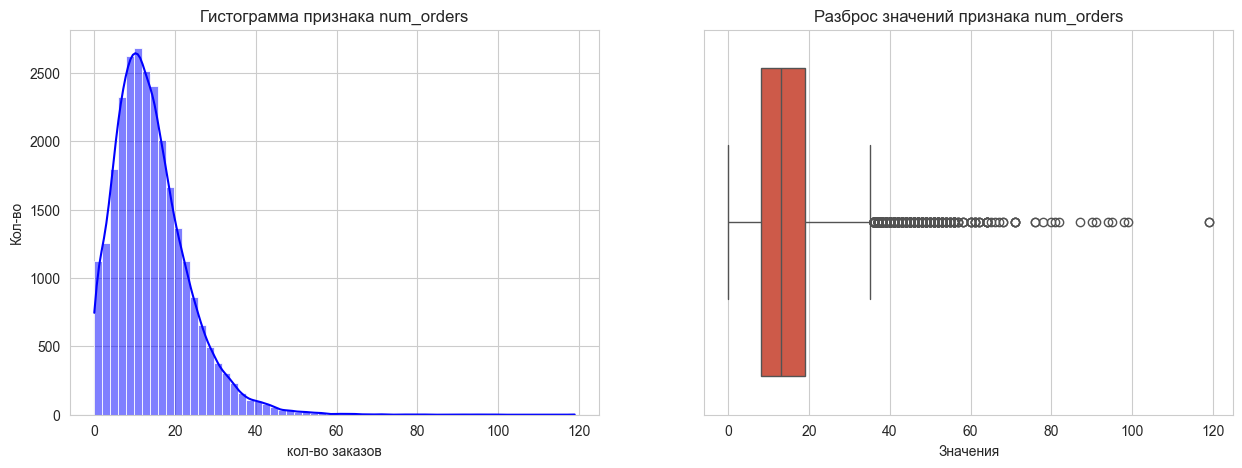

In [15]:
graph_num(df, 'num_orders', 'num_orders', 'кол-во заказов', bins=60)

Проанализируем значения 0 , для выявления является ли это на значение пропуском(аномалией) или фактическим значением.

In [16]:
df_graph = df.copy()

In [17]:
df_graph['hour'] = df.index.hour

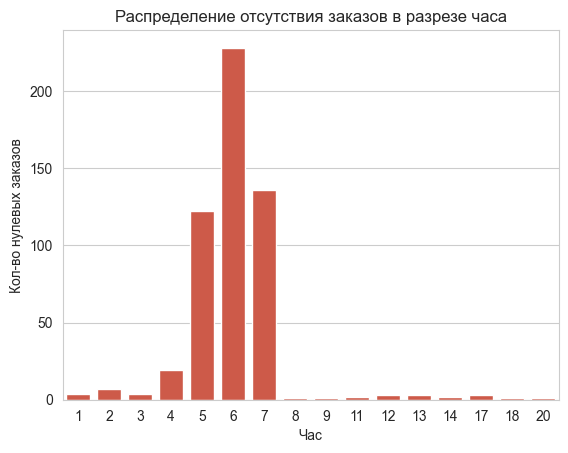

In [18]:
filtered_df = df_graph[df_graph['num_orders'] == 0]
filtered_df = filtered_df.groupby('hour').agg('count')
sns.barplot(data=filtered_df, x='hour', y='num_orders')
plt.xlabel('Час')
plt.ylabel('Кол-во нулевых заказов')
plt.title('Распределение отсутствия заказов в разрезе часа')
plt.show()

Видим что основная масса отсутствующих(нулевых) заказов приходится на утренние часы , что вполне согласуется с реальностью.

Оставим нулевые значения без обработки.

**Анализ повышенного спроса(выбросов) в течении дня**

Выберем значение заказов в 35 как отправную для определения повышения спроса.

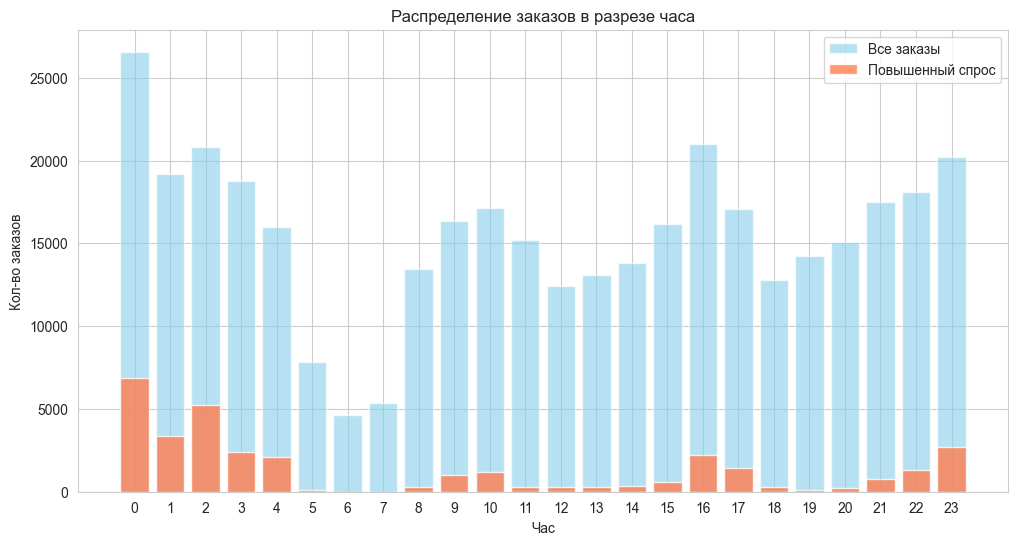

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

filtered_df = df_graph.groupby('hour').agg(['sum']).reset_index()
filtered_dff = df_graph[df_graph['num_orders'] >= 35].groupby('hour').agg(['sum']).reset_index()

filtered_df.columns = ['hour', 'total_orders']
filtered_dff.columns = ['hour', 'high_orders']

ax.bar(filtered_df['hour'], filtered_df['total_orders'], 
       alpha=0.6, label='Все заказы', color='skyblue')
ax.bar(filtered_dff['hour'], filtered_dff['high_orders'], 
       alpha=0.8, label='Повышенный спрос', color='coral')

ax.set_xlabel('Час')
ax.set_ylabel('Кол-во заказов')
ax.set_title('Распределение заказов в разрезе часа')
ax.legend()
plt.xticks(filtered_df['hour'])
plt.show()

Наблюдается прямая зависимость: спрос на такси значительно возрастает в часы, когда прекращается работа общественного транспорта или присутствует большая загруженность.



### Ресемплинг и создание новых фичей.

Выполним ресемплинг нашего набора данных , увеличив временной интервал до 1 часа.

In [20]:
df_res = df.resample('1H').sum()
df_res.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Извлечем из индекса значения часа,месяца,дня недели для добавления в качестве новых признаков.

In [21]:
df_res['hour'] = df_res.index.hour
df_res['dow'] = df_res.index.dayofweek
df_res['dom'] = df_res.index.day
df_res['month'] = df_res.index.month

In [22]:
df_res.head(10)

,num_orders,hour,dow,dom,month
datetime,,,,,
2018-03-01 00:00:00,124,0,3,1,3
2018-03-01 01:00:00,85,1,3,1,3
2018-03-01 02:00:00,71,2,3,1,3
2018-03-01 03:00:00,66,3,3,1,3
2018-03-01 04:00:00,43,4,3,1,3
2018-03-01 05:00:00,6,5,3,1,3
2018-03-01 06:00:00,12,6,3,1,3
2018-03-01 07:00:00,15,7,3,1,3
2018-03-01 08:00:00,34,8,3,1,3


**Проанализируем кол-во заказов относительно новосозданных признаков.**

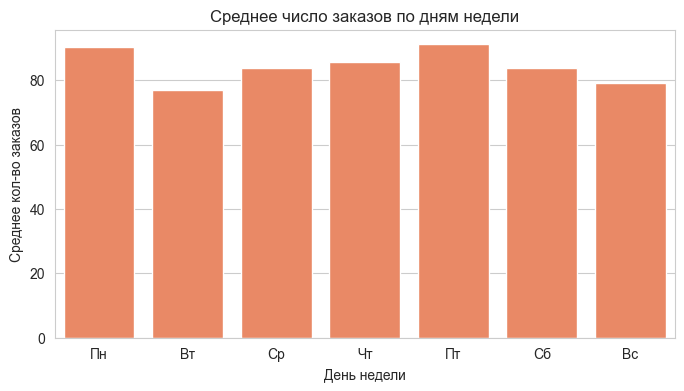

In [23]:
avg = df_res.groupby('dow')['num_orders'].mean().reset_index()
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.figure(figsize=(8, 4))
sns.barplot(data=avg, x='dow', y='num_orders', color='coral')
plt.xlabel('День недели')
plt.xticks(ticks=range(7), labels=days)
plt.ylabel('Среднее кол-во заказов')
plt.title('Среднее число заказов по дням недели')
plt.show()

Видим небольшую зависимость количества заказов от дня недели. В понедельник и пятницу наблюдается увеличение спроса , возможно это связанно с тем что в пятницу совершается большее количество поездок на выходные(отдых, переговоры, командировки) , а в понедельник люди возвращаются к своей обычной рабочей неделе.

**Проведем аналогичный анализ для месяцев.**

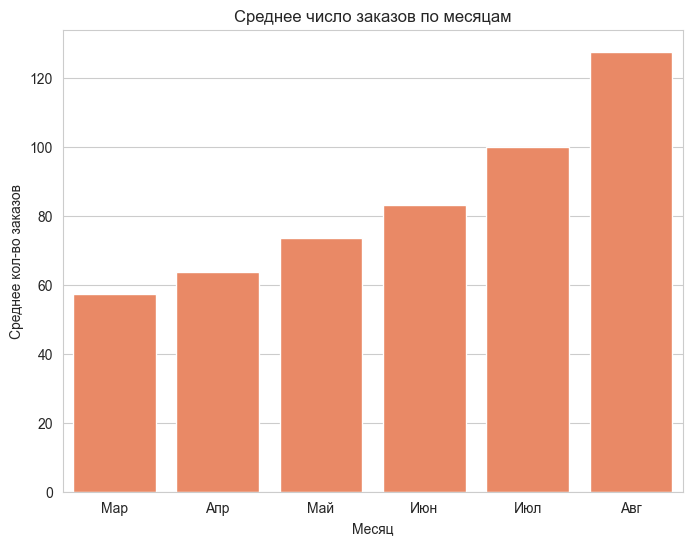

In [24]:
avg = df_res.groupby('month')['num_orders'].mean().reset_index()
months = ['Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг']

plt.figure(figsize=(8, 6))
sns.barplot(data=avg, x='month', y='num_orders', color='coral')
plt.xlabel('Месяц')
plt.xticks(ticks=range(len(months)), labels=months)
plt.ylabel('Среднее кол-во заказов')
plt.title('Среднее число заказов по месяцам')
plt.show()

Виден явный тренд на увеличения заказов такси. С наступлением весенне-летнего сезона кол-во отдыхающих резко возрастает и основным способом добраться до аэропорта является такси.

### Декомпозиция данных и анализ сезонности и тренда

In [25]:
dec = seasonal_decompose(df_res.drop(['hour', 'dow', 'dom', 'month'], axis=1))

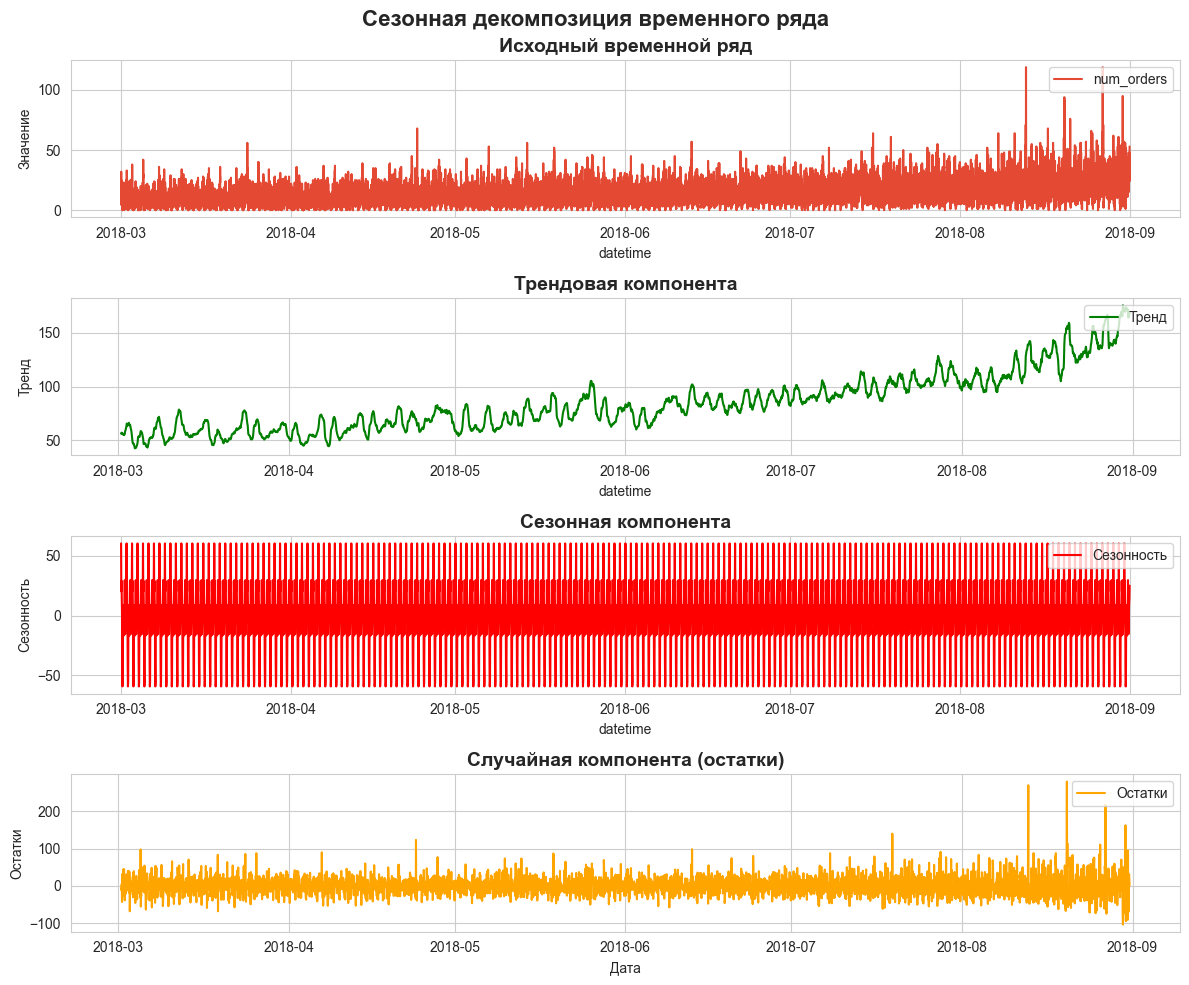

In [26]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
fig.suptitle('Сезонная декомпозиция временного ряда', fontsize=16, fontweight='bold')

# Исходный ряд
sns.lineplot(data=df, ax=axes[0], color='blue')
axes[0].set_title('Исходный временной ряд', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Значение')
axes[0].legend(loc='upper right')

# Тренд
sns.lineplot(data=dec.trend, ax=axes[1], color='green', label='Тренд')
axes[1].set_title('Трендовая компонента', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Тренд')
axes[1].legend(loc='upper right')

# Сезонность
sns.lineplot(data=dec.seasonal, ax=axes[2], color='red', label='Сезонность')
axes[2].set_title('Сезонная компонента', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Сезонность')
axes[2].legend(loc='upper right')

# Остатки
sns.lineplot(data=dec.resid, ax=axes[3], color='orange', label='Остатки')
axes[3].set_title('Случайная компонента (остатки)', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Остатки')
axes[3].set_xlabel('Дата')
axes[3].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Место для общего заголовка
plt.show()

Проанализировав графики мы можем сказать что :

- С приходом летнего периода наблюдается восходящий тренд с резким *взлетом* в июле, августе. Это связанно с наступлением сезона отпусков и нагрузка на аэропорты , а следовательно и на сервис заказа такси возрастает.

- Так же видны дневные колебания количества заказов , что вполне логично что в ночное время спрос падает.

-  По остаткам мы видим что активность пользователей в августе носит хаотический характер , без выраженной закономерности.

### Проверка на стационарность ряда при помощи теста Дики-Фуллера

Выдвинем нулевую гипотезу о том что ряд не стационарен и проверим это при помощи теста Дики-Фуллера.

In [27]:
def adf_test(series, alpha=0.05):
    """
    Выполняет тест Дики-Фуллера и выводит результаты в удобном формате
    """
    print("Результаты теста Дики-Фуллера:")
    print("=" * 50)
    
    result = adfuller(series, autolag='AIC')
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    print(f"ADF статистика: {adf_statistic:.6f}")
    print(f"p-value: {p_value}")
    print("Критические значения:")
    for key, value in critical_values.items():
        print(f"\t{key}: {value:.6f}")
    
    # Интерпретация результатов
    print("\nИнтерпретация:")
    print("-" * 30)
    if p_value < alpha:
        print("✅ p-value < 0.05: Отвергаем нулевую гипотезу")
        print("Ряд СТАЦИОНАРЕН")
    else:
        print("❌ p-value >= 0.05: Не отвергаем нулевую гипотезу")
        print("Ряд НЕ СТАЦИОНАРЕН")
    


In [28]:
adf_test(df['num_orders'], 0.05)

Результаты теста Дики-Фуллера:
ADF статистика: -12.548885
p-value: 2.2286378815479788e-23
Критические значения:
	1%: -3.430597
	5%: -2.861649
	10%: -2.566828

Интерпретация:
------------------------------
✅ p-value < 0.05: Отвергаем нулевую гипотезу
Ряд СТАЦИОНАРЕН


Тест показал что ряд стационарен , а значит в целом хорошо поддается прогнозированию моделями МО.

### Создание функции для расчета скользящего среднего и смещения.

In [29]:
def features(df, max_lag, rolling):
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling).mean()
    
    return df

Так как в данных представлена информация всего лишь за 6 месяцев , уберем из датасета параметр месяца , что не путать модель.

In [30]:
df_res.drop('month', axis=1, inplace=True)

In [31]:
df_res_fin = features(df_res,1,24)
df_res_fin.dropna(inplace=True)
df_res_fin.head(5)

,num_orders,hour,dow,dom,lag_1,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,0,4,2,58.0,56.833333
2018-03-02 01:00:00,120,1,4,2,90.0,55.416667
2018-03-02 02:00:00,75,2,4,2,120.0,56.875000
2018-03-02 03:00:00,64,3,4,2,75.0,57.041667
2018-03-02 04:00:00,20,4,4,2,64.0,56.958333


### Вывод

- Мы добавили в наш датасет несколько новых признаков основанных на дате и времени заказа.

- Так же добавили в набор данных параметры *смещения* и *скользящего среднего* с возможностью выбора нужного значения.

- В процессе работы удалось установить явный восходящий тренд увеличения заказов такси с приближением к летним месяца.


- Установили что с наступлением ночи , темпы заказов резко начинают падать и восстанавливаются с наступлением утра.


- Удалось заметить незначительное колебание кол-ва заказов в сторону увеличения в понедельник и пятницу.


- Провели тест Дики-Фуллера , который помог установить стационарность значений заказов на всем промежутке наблюдений.




## Обучение моделей.

### Подготовка выборок

Выполним разделение на тестовую и тренировочную выборки.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_res_fin.drop('num_orders', axis=1), df_res_fin['num_orders'], shuffle=False, test_size=0.1, random_state=RS)

In [33]:
X_train.head(5)

,hour,dow,dom,lag_1,rolling_mean
datetime,,,,,
2018-03-02 00:00:00,0,4,2,58.0,56.833333
2018-03-02 01:00:00,1,4,2,90.0,55.416667
2018-03-02 02:00:00,2,4,2,120.0,56.875000
2018-03-02 03:00:00,3,4,2,75.0,57.041667
2018-03-02 04:00:00,4,4,2,64.0,56.958333


In [34]:
y_train.head(5)

datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
Freq: h, Name: num_orders, dtype: int64

In [35]:
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['hour', 'dow', 'dom', 'lag_1', 'rolling_mean'], dtype='object')

Определим список моделей и тип стандартизации данных.

In [36]:
# Создадим заглущки , а параметры будем перебирать в models
numeric_transformer = Pipeline([
    ('scaler', 'passthrough'),  
    ('preprocessor', None)      
])

# cat_transformer = Pipeline([
#     ('encoder', 'passthrough'),  
#     ('preprocessor', None)      
# ])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        # ('cat', cat_transformer, cat_cols) 
    ],
    remainder='passthrough',
    transformer_weights=None)

In [37]:
models = {
    'DecisionTree': {
        'model': DecisionTreeRegressor(random_state=RS),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
            'regressor__max_depth': [3, 5, 7, 10, None],
            'regressor__min_samples_split': [2, 5, 10, 20],
            'regressor__min_samples_leaf': [1, 2, 5, 10],
            'regressor__max_features': ['sqrt', 'log2', None]
        }
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
            'regressor__C': [0.1, 1, 10],
            'regressor__kernel': ['linear', 'rbf'],
            'regressor__gamma': ['scale', 'auto', 0.1]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
            'regressor__n_neighbors': [3, 5, 7, 10, 15],
            'regressor__weights': ['uniform', 'distance'],
            'regressor__metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=RS, verbose=-1),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
            'regressor__n_estimators': [50, 100],
            'regressor__learning_rate': [0.01, 0.05],
            'regressor__max_depth': [3, 5],
            'regressor__num_leaves': [31, 50],
            'regressor__subsample': [0.8, 0.9],
            'regressor__colsample_bytree': [0.8, 0.9],
            'regressor__reg_alpha': [0, 0.1],
            'regressor__reg_lambda': [0, 0.1]
        }
    }
}

In [38]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

rmse_scorer = make_scorer(lambda y_true, y_pred: 
                          np.sqrt(mean_squared_error(y_true, y_pred)),
                          greater_is_better=False)

results = {}

for name, config in models.items():
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring=rmse_scorer,
        refit=True, 
        cv=tscv,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_rmse': -grid.best_score_,  # отрицательное, т.к. greater_is_better=False
        'mean_fit_time': grid.cv_results_['mean_fit_time'].mean()
    }
    
    print(f"{name} completed.")
    print(f"Best RMSE: {results[name]['best_rmse']:.4f}")
    print("-" * 50)

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

for name, res in results.items():
    print(f"{name}:")
    print(f"Best RMSE: {res['best_rmse']:.4f}")
    print(f"Mean Fit Time: {res['mean_fit_time']:.2f}s")
    print("-" * 40)

# Создаем DataFrame для сравнения моделей
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [res['best_rmse'] for res in results.values()],
    'Fit_Time': [res['mean_fit_time'] for res in results.values()]
})

print("\nCOMPARISON TABLE (sorted by RMSE)")
print("="*40)
print(results_df.sort_values('RMSE').round(4))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
DecisionTree completed.
Best RMSE: 27.2931
--------------------------------------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits
LinearRegression completed.
Best RMSE: 31.8172
--------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits
SVR completed.
Best RMSE: 31.7887
--------------------------------------------------
Fitting 5 folds for each of 120 candidates, totalling 600 fits
KNeighborsRegressor completed.
Best RMSE: 29.1501
--------------------------------------------------
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
LightGBM completed.
Best RMSE: 25.9409
--------------------------------------------------

FINAL RESULTS SUMMARY
DecisionTree:
Best RMSE: 27.2931
Mean Fit Time: 0.01s
----------------------------------------
LinearRegression:
Best RMSE: 31.8172
Mean Fit Time: 0.01s
----------------------------------------
S

Протестировав несколько моделей , лучшей оказалась LightGBM с результатом на тренировочной выборке в 25 по метрике RMSE.

### Проверка лучшей модели на тестовых данных.

Передадим модели тестовые данные для получения результатов и дальнейшего сравнения со значениями на тренировочной выборке.

In [39]:
model = results['LightGBM']['best_model']
model

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
y_pred = model.predict(X_test)


In [41]:
rmse_value = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_value:.4f}")

RMSE: 45.5736


### График предсказаний и фактических значений.

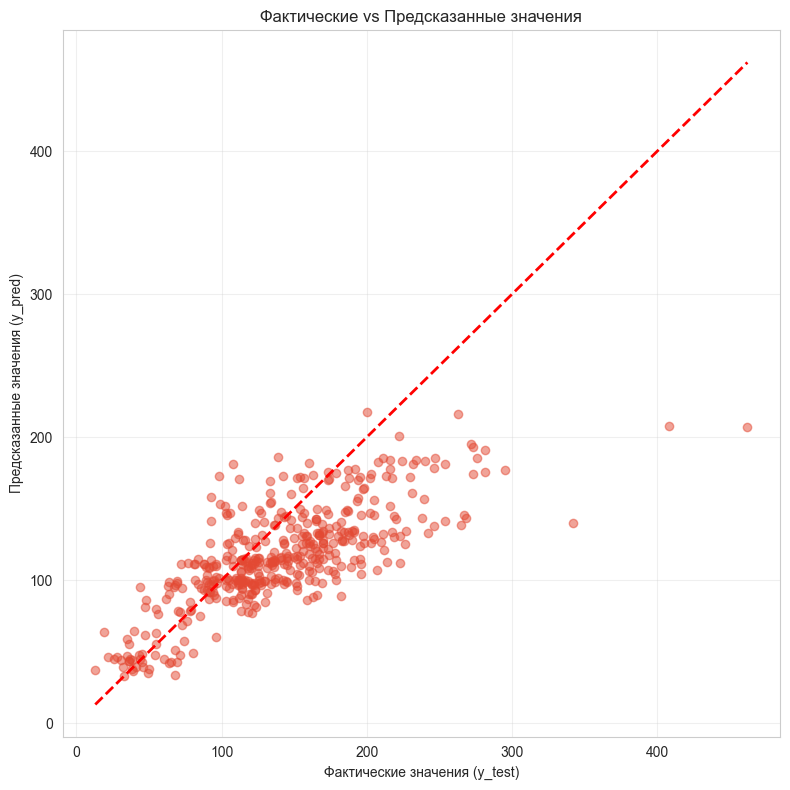

In [42]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения (y_test)')
plt.ylabel('Предсказанные значения (y_pred)')
plt.title('Фактические vs Предсказанные значения')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

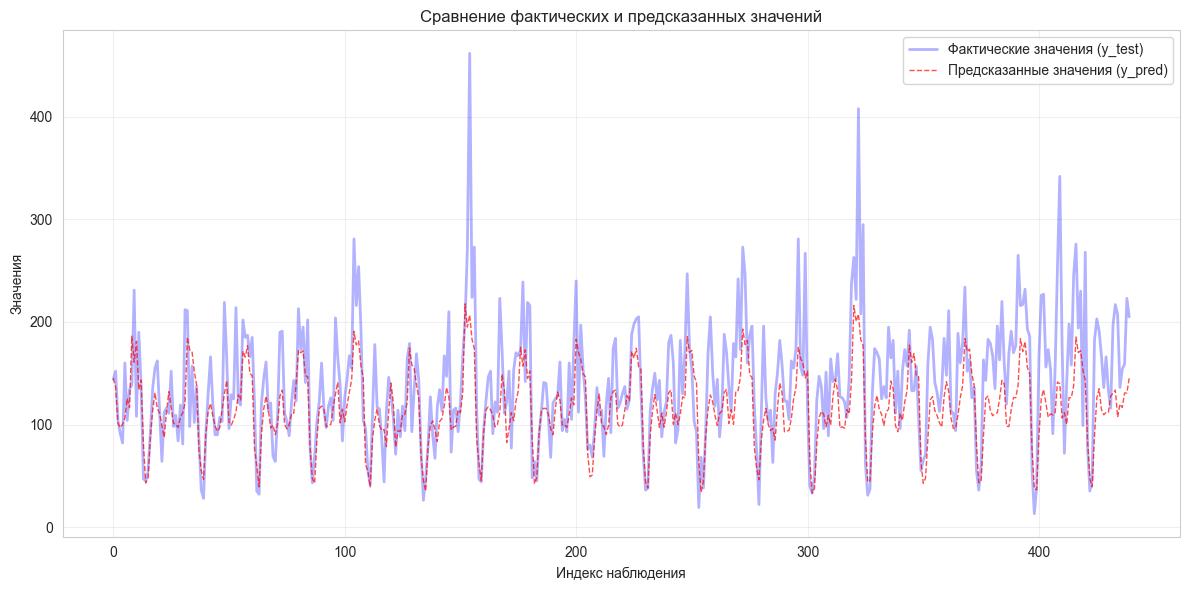

In [43]:
plt.figure(figsize=(12, 6))
indices = np.arange(len(y_test))

plt.plot(indices, y_test, 'b-', label='Фактические значения (y_test)', linewidth=2, alpha=0.3)
plt.plot(indices, y_pred, 'r--', label='Предсказанные значения (y_pred)', linewidth=1, alpha=0.7)

plt.xlabel('Индекс наблюдения')
plt.ylabel('Значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Видим что наша модель плохо предсказывает значения выше 200 , это вызвано тем что обучали мы её на данных за март-июль где показатели заказов были более равномерные , а тестировали на данных за август где значения принимали аномально высокие значения относительно остальных месяцев.

Видим резкое снижение результатов до ~45 значения RMSE что практически в два раза хуже чем на тренировочной выборку. Ухудшение метрики возможно связанно с тем что при делении на выборки, в тестовую попали данные за август которые содержат аномальные высокие значения относительно остального датасета.

Не смотря на ухудшение качества предсказаний, поставленных заказчиком требований удалось добиться.

### Вывод

- Мы провели тестирование 5 разных моделей МО , а именно (LightGBM , DecisionTree, KNeighborsRegressor, SVR, LinearRegression) с целью выявить лучшую.

- По результатам работы первое место заняла модель испольщующая в своей основе метод градиентного бустинга LightGBM с результатом на тренировочных данных в 25 по RMSE метрике.

- Модель переобучилась , возможно при подготовке признаков следовало использовать другие значения *сдвига* и *скользящего среднего* 

- Поставленная заказчиком задача решена финальная метрика на тестовых данных меньше 48 а именно ~45 по метрике RMSE.

## Финальный вывод 

К нам обратился заказчик их компании «Чётенькое такси» с целью разработать модель для предсказания спроса на такси в зонах аэропорта, вот чего нам удалось достичь :

- Мы загрузили присланные заказчиком данные , на первый взгляд аномалий и дефектов в данных не наблюдалось.

- Мы провели анализ нулевых значений и *выбросов* и пришли к заключению что данные в порядке и могут быть использованны в создании модели.

- На этапе дальнейшей подготовки данных мы выделили из временных значений : час, день недели , день месяца, и сам месяц и добавили в исходный датасет.

- Так же мы создали функцию способную задавать новые признаки , такие как значение скользящего среднего и смещения.

- Так же при анализе данных удалось установить явную сезонность кол-во заказов с приближением к летним месяцам резко увеличивалось , а так же дни недели *(понедельник и пятница)* с повышенным спросом.

- Перебрали несколько моделей машинного обучения и остановились на LightGBM с результатом 25 на тренировочных данных и 45 на тестовых по метрике RMSE. Что полностью удовлетворяет требования заказчика.

### Рекомендации

- Для улучшений прогнозирования спроса на такси , следовалобы начать собирать данные о погоде в уже существующий 10 минутный временной промежуток, к примеру ввести бинарную переменную raining. Учитывая сезонный характур наших данных , а именно весенне-летный период , данные о погоде могли бы помочь в предсказание резкого увеличения спроса в следующий час и сокрашения времени ожидания что повысило бы лояльность пользователей.